Using device: cpu
Loading YOLOv8 model...
Loading Faster R-CNN model...
Models loaded successfully!

==== Object Detection System ====
1. Image Detection
2. Video Processing
3. Real-Time Detection
4. Exit

Upload an image file:


Saving Image1.png to Image1.png
Processing time: 13.66s


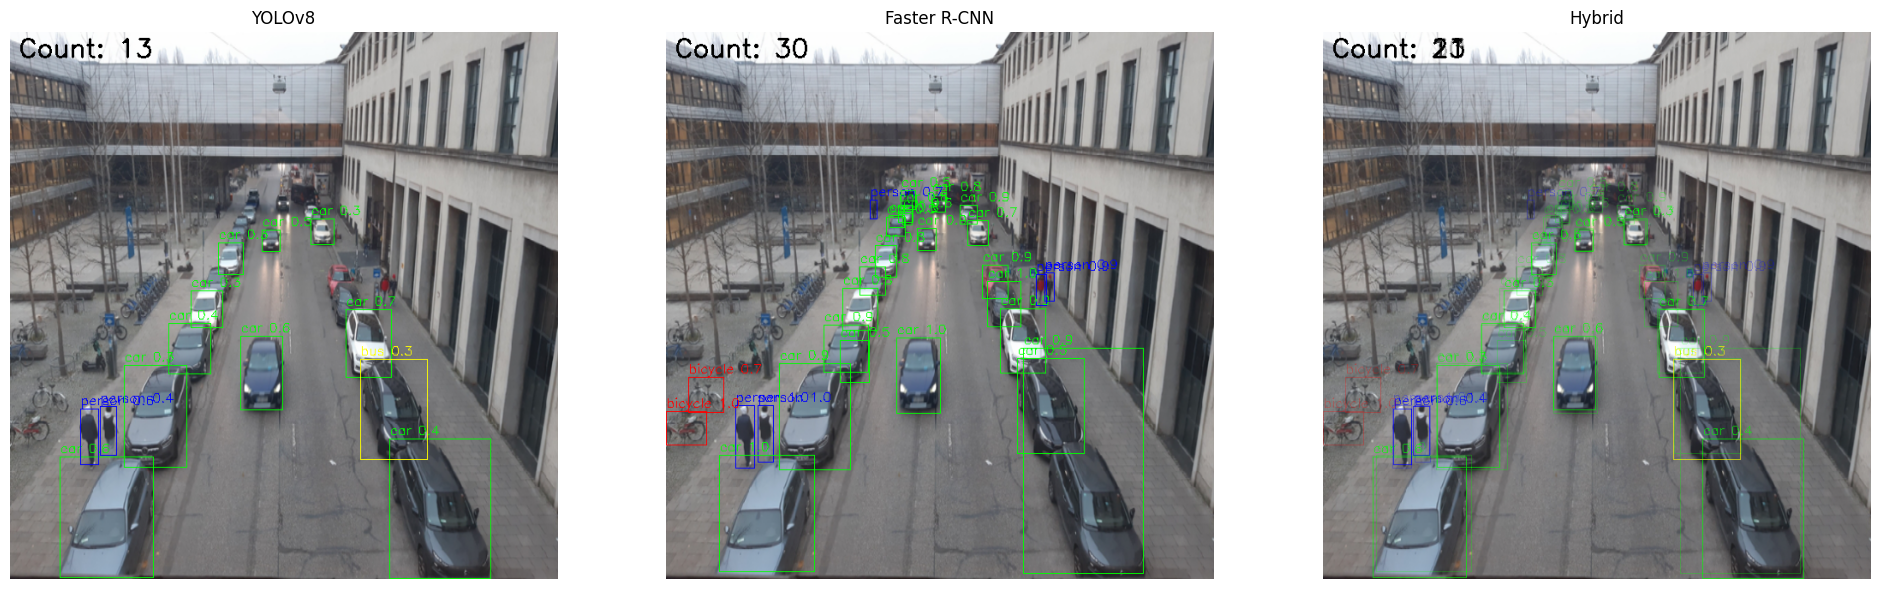


==== Object Detection System ====
1. Image Detection
2. Video Processing
3. Real-Time Detection
4. Exit

Upload an image file:


Saving Image2.jpg to Image2.jpg
Processing time: 13.38s


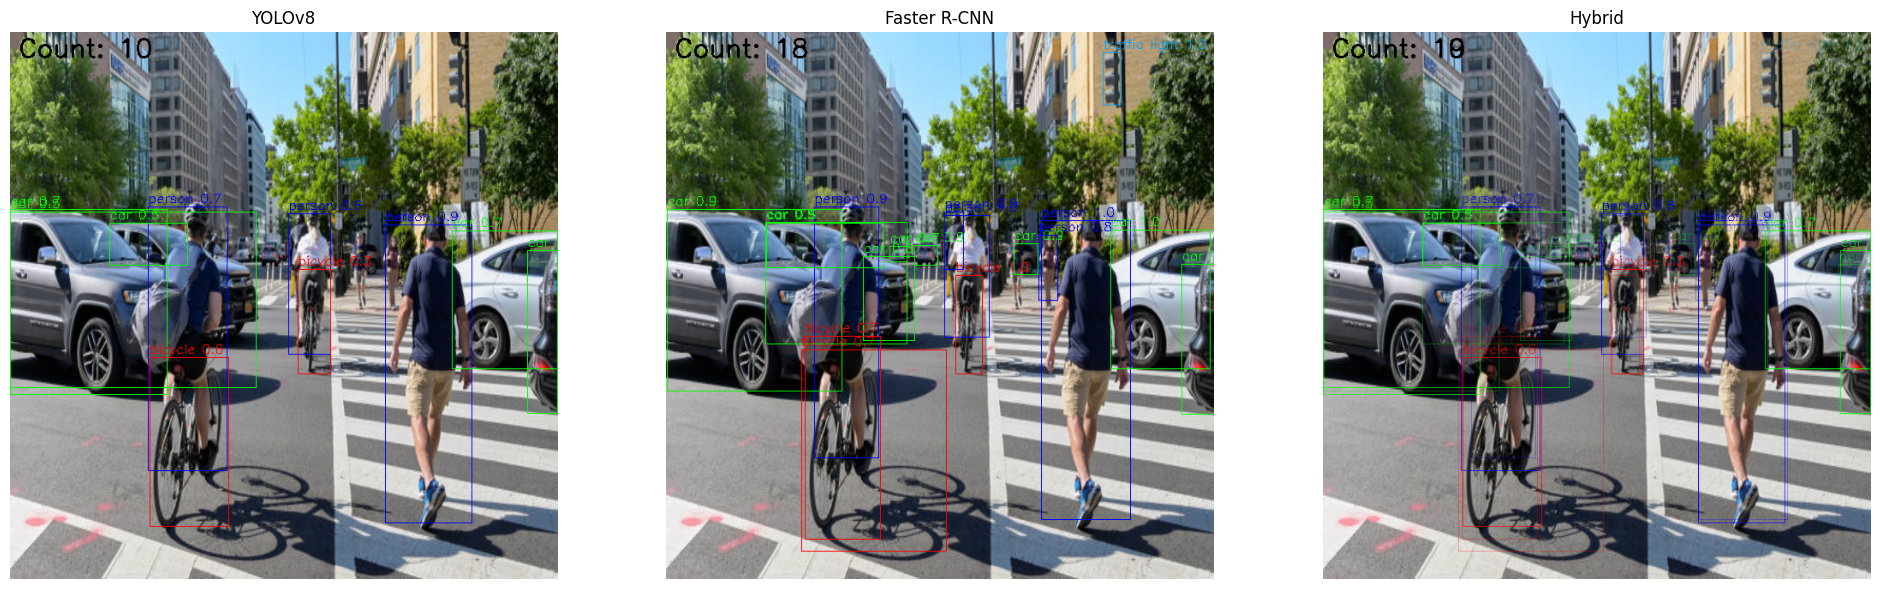


==== Object Detection System ====
1. Image Detection
2. Video Processing
3. Real-Time Detection
4. Exit

Upload a video file:


Saving car video.mp4 to car video.mp4

Select Detection Approach: 1. YOLOv8 2. Faster R-CNN 3. Hybrid
Processed 30 frames


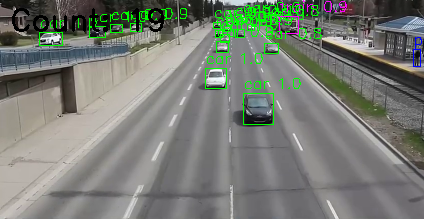

Processed 60 frames


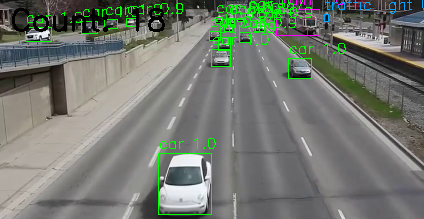

Processed 90 frames


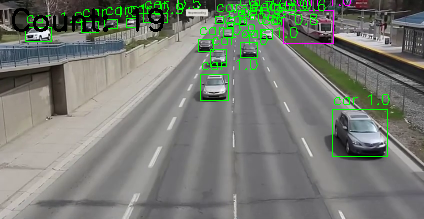

Processed 120 frames


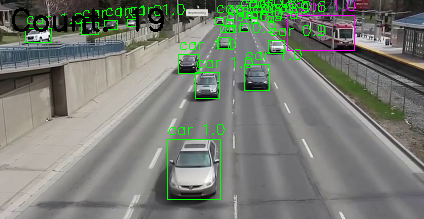

Processed 150 frames


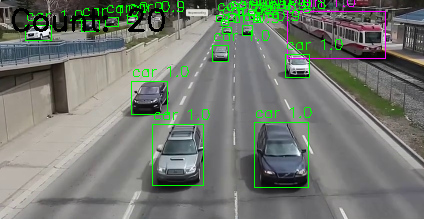

Processing complete! Downloading output_car video_rcnn.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


==== Object Detection System ====
1. Image Detection
2. Video Processing
3. Real-Time Detection
4. Exit
Select option (1-4): 4


In [3]:
# ======================
# MODULE 1: Imports & Setup
# ======================
!pip install ultralytics

import cv2
import numpy as np
import torch
import torchvision
from ultralytics import YOLO
from google.colab import files
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import traceback

# COCO class names
COCO_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Color mapping
COLORS = {
    'car': (0, 255, 0), 'person': (255, 0, 0), 'bicycle': (0, 0, 255), 'truck': (255, 255, 0),
    'bus': (0, 255, 255), 'train': (255, 0, 255), 'motorcycle': (128, 0, 128),
    'traffic light': (255, 165, 0), 'stop sign': (0, 0, 139), 'default': (128, 128, 128)
}

# ======================
# MODULE 2: Model Loading
# ======================
def load_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    yolo_model = rcnn_model = None

    try:
        print("Loading YOLOv8 model...")
        yolo_model = YOLO("yolov8n.pt").to(device)
    except Exception as e:
        print(f"Error loading YOLOv8: {e}")
        traceback.print_exc()

    try:
        print("Loading Faster R-CNN model...")
        weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(device)
        rcnn_model.eval()
        print("Models loaded successfully!")
    except Exception as e:
        print(f"Error loading Faster R-CNN: {e}")
        traceback.print_exc()

    return yolo_model, rcnn_model, device

# ======================
# MODULE 3: Detection Functions
# ======================
def yolo_detect(model, frame, conf_thres=0.25):
    if model is None:
        return frame

    imgsz = (320, 320)
    if len(frame.shape) == 2:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    elif frame.shape[2] == 4:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
    else:
        frame_bgr = frame.copy()

    results = model(frame_bgr, verbose=False, conf=conf_thres, imgsz=imgsz)
    annotated = frame.copy()

    results = [results] if not isinstance(results, list) else results

    detected = 0
    for res in results:
        if res.boxes is not None:
            for *xyxy, conf, cls in res.boxes.data.cpu().numpy():
                detected += 1
                x1, y1, x2, y2 = map(int, xyxy)
                label = res.names[int(cls)]
                color = COLORS.get(label.lower(), COLORS['default'])
                cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 1)
                cv2.putText(annotated, f"{label} {float(conf):.1f}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # ---------- ADDED: OBJECT COUNT ----------
    cv2.putText(annotated, f"Count: {detected}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    return annotated


def rcnn_detect(model, frame, confidence=0.5):
    if model is None:
        return frame

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if len(frame.shape) == 3 else cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    transform = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT.transforms()
    img_tensor = transform(Image.fromarray(frame_rgb)).unsqueeze(0).to(next(model.parameters()).device)

    with torch.no_grad():
        pred = model(img_tensor)[0]

    annotated = frame.copy()
    keep = pred['scores'].cpu().numpy() > confidence

    detected = keep.sum()

    for box, label_id, score in zip(pred['boxes'][keep].cpu().numpy(),
                                    pred['labels'][keep].cpu().numpy(),
                                    pred['scores'][keep].cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)
        label = COCO_NAMES[label_id] if 0 < label_id <= len(COCO_NAMES) else f"Class {label_id}"
        color = COLORS.get(label.lower(), COLORS['default'])
        cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 1)
        cv2.putText(annotated, f"{label} {float(score):.1f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # ---------- ADDED: OBJECT COUNT ----------
    cv2.putText(annotated, f"Count: {detected}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    return annotated


def hybrid_detect(yolo_model, rcnn_model, frame, yolo_conf=0.25, rcnn_conf=0.5):
    yolo_res = yolo_detect(yolo_model, frame, yolo_conf)
    if rcnn_model is None:
        return yolo_res
    rcnn_res = rcnn_detect(rcnn_model, frame, rcnn_conf)

    hybrid = None
    if yolo_res.shape == rcnn_res.shape:
        hybrid = cv2.addWeighted(yolo_res, 0.7, rcnn_res, 0.3, 0)
    else:
        hybrid = yolo_res

    # Count using YOLO (simple and fast)
    count = len(yolo_model(frame, conf=yolo_conf, verbose=False)[0].boxes)

    # ---------- ADDED: OBJECT COUNT ----------
    cv2.putText(hybrid, f"Count: {count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    return hybrid

# ======================
# MODULE 4: Image Processing
# ======================
def process_image(yolo_model, rcnn_model, device):
    print("\nUpload an image file:")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded!")
        return

    filename = next(iter(uploaded))
    img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error loading image {filename}")
        return

    img_resized = cv2.resize(img, (640, 640))
    start = time.time()
    yolo_res = yolo_detect(yolo_model, img_resized)
    rcnn_res = rcnn_detect(rcnn_model, img_resized)
    hybrid_res = hybrid_detect(yolo_model, rcnn_model, img_resized)
    print(f"Processing time: {time.time() - start:.2f}s")

    plt.figure(figsize=(24, 8))
    for i, (res, title) in enumerate(zip([yolo_res, rcnn_res, hybrid_res],
                                         ["YOLOv8", "Faster R-CNN", "Hybrid"])):
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.show()

# ======================
# MODULE 5: Video Processing
# ======================
def process_video(yolo_model, rcnn_model, device):
    print("\nUpload a video file:")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded!")
        return

    filename = next(iter(uploaded))
    cap = cv2.VideoCapture(filename)
    if not cap.isOpened():
        print(f"Error opening video {filename}")
        return

    print("\nSelect Detection Approach: 1. YOLOv8 2. Faster R-CNN 3. Hybrid")
    approach = input("Select approach (1-3): ")

    width, height, fps = int(cap.get(3)), int(cap.get(4)), cap.get(cv2.CAP_PROP_FPS)
    frame_skip = 3
    out_file = f'output_{os.path.splitext(filename)[0]}_{"yolo" if approach=="1" else "rcnn" if approach=="2" else "hybrid"}.mp4'
    writer = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc(*'mp4v'), fps / frame_skip, (width//2, height//2))

    frame_count, start_time = 0, time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % frame_skip != 0:
            continue
        frame_resized = cv2.resize(frame, (width//2, height//2))
        processed = None
        if approach == '1' and yolo_model: processed = yolo_detect(yolo_model, frame_resized)
        elif approach == '2' and rcnn_model: processed = rcnn_detect(rcnn_model, frame_resized)
        elif approach == '3' and yolo_model and rcnn_model: processed = hybrid_detect(yolo_model, rcnn_model, frame_resized)
        if processed is not None:
            writer.write(processed)
            if frame_count % (10*frame_skip) == 0:
                print(f"Processed {frame_count} frames")
                try: cv2_imshow(processed)
                except: pass

    cap.release()
    writer.release()
    print(f"Processing complete! Downloading {out_file}")
    try: files.download(out_file)
    except: pass

# ======================
# MODULE 6: Real-Time Detection
# ======================
def realtime_detection(yolo_model, rcnn_model, device):
    print("\nReal-Time Options: 1. Webcam 2. Video File")
    source = input("Select source (1-2): ")
    cap = cv2.VideoCapture(0 if source=='1' else None)
    if source == '2':
        uploaded = files.upload()
        if not uploaded: return
        cap = cv2.VideoCapture(next(iter(uploaded)))
    if not cap or not cap.isOpened(): return

    print("Select Detection Approach: 1. YOLOv8 2. Faster R-CNN 3. Hybrid")
    approach = input("Select approach (1-3): ")
    width, height = int(cap.get(3)), int(cap.get(4))
    frame_skip, frame_count, start_time = 2, 0, time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % frame_skip != 0: continue
        frame_resized = cv2.resize(frame, (width//2, height//2))
        result = None
        if approach=='1' and yolo_model: result=yolo_detect(yolo_model, frame_resized)
        elif approach=='2' and rcnn_model: result=rcnn_detect(rcnn_model, frame_resized)
        elif approach=='3' and yolo_model and rcnn_model: result=hybrid_detect(yolo_model, rcnn_model, frame_resized)
        if result is not None:
            fps = frame_count / max(time.time() - start_time, 1e-5)
            cv2.putText(result, f"FPS: {fps:.1f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),1)
            try: cv2_imshow(result)
            except: pass

    cap.release()
    print("Stopped video stream.")

# ======================
# MODULE 7: Main Menu
# ======================
def main():
    yolo_model, rcnn_model, device = load_models()
    if not yolo_model and not rcnn_model:
        print("No models loaded. Exiting.")
        return

    while True:
        print("\n==== Object Detection System ====")
        print("1. Image Detection\n2. Video Processing\n3. Real-Time Detection\n4. Exit")
        choice = input("Select option (1-4): ")
        if choice=='1': process_image(yolo_model, rcnn_model, device)
        elif choice=='2': process_video(yolo_model, rcnn_model, device)
        elif choice=='3': realtime_detection(yolo_model, rcnn_model, device)
        elif choice=='4': break
        else: print("Invalid choice!")

if __name__ == "__main__":
    main()



